# Conformal Quantile Regression for CATE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 8})

É importante quantificar a incerteza da previsão de alguma forma e conformal prediction te da um bom jeito pra fazer isso...

- TODO: Explicar um pouco por cima (baseado no KDE, mas bem mais reduzido).

- TODO: Explicar bem por cima o que é o CATE usando o do(X=x). Comentar que é ligeiramente mais díficil a tarefa de incerteza aqui porque não é só uma quantidade e sim a soma de duas estimativas.

- TODO: Falar bem por cima que um jeito de estimar o cate é utilizando o criterio backdoor com a formula do ajuste. falar que o o do(X=x), Z=z vira X=x, Z=z somente nesse caso, e dai isso é uma regressão.

- TODO: Comentar que vamos juntar essa duas coisas aqui.

Para exemplificar, vamos utilizar o seguinte grafo causal:

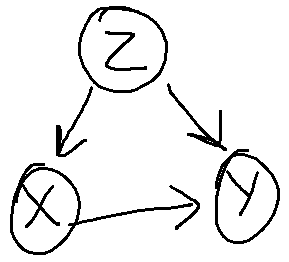

Com grafo causal estrutural dado por:

$$U_Z \sim \textrm{Uniform}(-\pi, \pi)\textrm{, with }g_Z(u_Z) = u_Z,$$

$$U_T \sim \textrm{Uniform}(0, 1)\textrm{, with } g_Z(u_T, z) = \mathbb{1}(u_T \leq 0.1 + 0.8\, \sigma(3z))\textrm{, where }\sigma(x) = \frac{1}{1 + \exp(-x)},$$

$$U_Y \sim \mathcal{N}(0, 1)\textrm{, with } g_Y(u_Y, z, t) = \mathbb{1}(t=0) (10 \sin(z)) + \mathbb{1}(t=1) (10 \cos(z)) + u_y.$$

In [2]:
def adapted_sigmoid(x):
    return 0.05 + 0.9 / (1 + np.exp(- x))

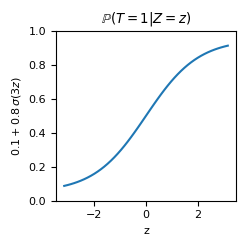

In [3]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.plot(np.linspace(- np.pi, np.pi), adapted_sigmoid(np.linspace(-np.pi, np.pi)))
ax.set_ylim(0, 1)
ax.set_title("$\mathbb{P}(T=1 | Z=z)$")
ax.set_xlabel("z")
ax.set_ylabel("$0.1 + 0.8 \,\sigma(3z)$")
plt.tight_layout()

In [4]:
def func_0(Z):
    return 10 * np.sin(Z)

def func_1(Z):
    return 10 * np.cos(Z)

def generate_data(size=100, obs=True, random_state=None):
    rs = np.random.RandomState(random_state).randint(
        0, 2**32 - 1, dtype=np.int64, size=4
    )
    
    Z_obs = np.random.RandomState(rs[0]).uniform(low=- np.pi, high=np.pi, size=size)
    
    def g_T_noised(Z):
        return np.random.RandomState(rs[1]).binomial(n=1, p=adapted_sigmoid(Z)).astype(bool)

    T_obs = g_T_noised(Z_obs)

    noise = np.random.RandomState(rs[3]).normal(size=size)

    def g_Y(T, Z, noise):
        return np.select(condlist=[T], choicelist=[func_1(Z)], default=func_0(Z)) + noise

    Y_obs = g_Y(T_obs, Z_obs, noise)
    Y_cf = g_Y(~T_obs, Z_obs, noise)
    
    def generate_df(T, Z, Y):
        return pd.DataFrame(np.vstack([T.astype(int), Z, Y]).T, columns=["treatment", "confounder", "target"])
    
    df_obs = generate_df(T_obs, Z_obs, Y_obs)
    df_cf = generate_df(~T_obs, Z_obs, Y_cf)
    
    return df_obs, df_cf

df_obs, df_cf = generate_data(size=100_000, obs=True, random_state=42)

- TODO: Vamos utilizar um conjunto separado para medir o quão bem estamos prevendo já que dessa vez temos tanto o obs quanto o contrafactual. Ou seja, conseguimos observar tanto Y_0 quanto Y_1.

- TODO: Comentar que isso é uma maneira ligeiramente diferente de definir o CATE, que concorda com a forma de do(X=x)

In [5]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df_obs.assign(target_cf=df_cf.target),
    test_size=0.2,
    random_state=42,
)

df_train_t0 = df_train.query("treatment == 0")
df_train_t1 = df_train.query("treatment == 1")

def return_XZ_y(df, backdoor_set_list):
    return df.filter(backdoor_set_list), np.array(df.target)

backdoor_set = ["confounder"]

XZ_train_t0, y_train_t0 = return_XZ_y(df_train_t0, backdoor_set)
XZ_train_t1, y_train_t1 = return_XZ_y(df_train_t1, backdoor_set)

XZ_test, y_test = return_XZ_y(df_test, backdoor_set)

Uma assumption que fica mascarada na teoria do Pearl, mas que vocÊ deveria sempre estudar é a Positivy Assumption.

TODO: enunciar ela e explicar porque ela é importante. como vou prever do(X=x) em regiões que nao tem ninguem com tal tratamento?

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

ps =  LogisticRegression(
    random_state=42,
).fit(df_train.drop(columns=["treatment", "target", "target_cf"]), df_train.treatment)

roc_auc_score(df_test.treatment, ps.predict_proba(XZ_test)[:, 1])

0.8331463706335919

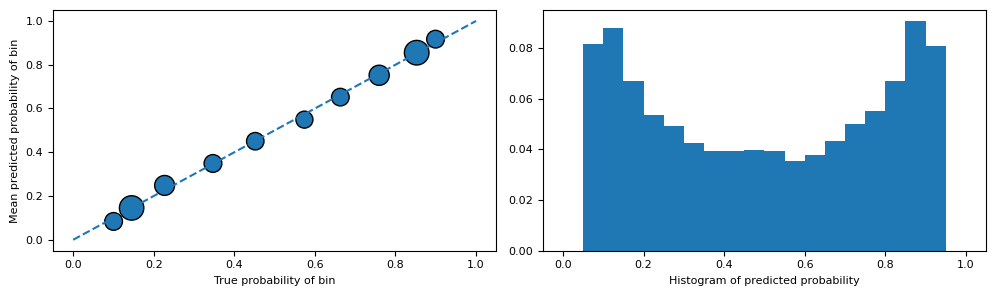

In [7]:
from cal import calibration_curve

probs = ps.predict_proba(XZ_test)[:, 1]
prob_true, prob_pred, size_bin = calibration_curve(df_test.treatment, probs, n_bins=10)

fig, ax = plt.subplots(ncols=2, figsize=(10, 3))
ax[0].plot([0, 1], "--")
ax[0].scatter(prob_true, prob_pred, s=(0.1 * size_bin).astype(int), edgecolor="k")
ax[0].set_xlabel("True probability of bin")
ax[0].set_ylabel("Mean predicted probability of bin")
ax[1].hist(probs, bins=np.linspace(0, 1, 21), weights=np.ones_like(probs)/probs.shape[0])
ax[1].set_xlabel("Histogram of predicted probability")
plt.tight_layout()

- TODO: enunciar como funciona o ConformalizedQuantileRegression em alguns tópicos. sem muuuito detalhe. colocar referencia.

In [8]:
from sklearn.base import BaseEstimator
from sklearn.utils.validation import check_X_y, check_is_fitted, _check_sample_weight
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV, KFold

from lightgbm import LGBMRegressor

from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import loguniform
from functools import partial

class ConformalizedQuantileRegression(BaseEstimator):
    def __init__(self, alpha=0.05, calibration_size=0.2, random_state=None, n_iter_cv=10):
        self.alpha = alpha
        self.calibration_size = calibration_size
        self.random_state = random_state
        self.n_iter_cv = n_iter_cv
    
    def quantile_loss(self, y_true, y_pred, quantile=None, sample_weights=None):
        weighted_errors = (y_true - y_pred) * (quantile - (y_true < y_pred))
        if sample_weights is not None:
            weighted_errors *= sample_weights
        return np.mean(weighted_errors)
    
    def _return_quantile_model(self, quantile):    
        quantile_scorer = make_scorer(partial(self.quantile_loss, quantile=quantile), greater_is_better=False)
        
        return RandomizedSearchCV(
            estimator=LGBMRegressor(random_state=self.random_state, objective='quantile', alpha=quantile),
            cv=KFold(shuffle=True, random_state=self.random_state),
            param_distributions={
                "learning_rate": loguniform.rvs(random_state=self.random_state, a=0.0001, b=1, size=1000),
                "n_estimators": [50, 100, 200],
                "num_leaves": [31, 63, 127],
            },
            scoring=quantile_scorer,
            n_iter=self.n_iter_cv,
            random_state=self.random_state,
            n_jobs=-1,
        )
    
    def fit(self, X, y, sample_weight=None):
        X, y = check_X_y(X, y)
        sample_weight = _check_sample_weight(sample_weight, X)
        
        X_train, X_cal, y_train, y_cal, sample_weight_train, sample_weight_cal = train_test_split(
            X, y, sample_weight, test_size=self.calibration_size, random_state=self.random_state)
        
        self.model_lower_ = self._return_quantile_model(quantile=self.alpha/2).fit(X_train, y_train, sample_weight=sample_weight_train)
        self.model_upper_ = self._return_quantile_model(quantile=1 - self.alpha/2).fit(X_train, y_train, sample_weight=sample_weight_train)
        
        self.y_cal_conformity_scores_ = np.maximum(
            self.model_lower_.predict(X_cal) - y_cal, 
            y_cal - self.model_upper_.predict(X_cal))
        wq = DescrStatsW(data=self.y_cal_conformity_scores_, weights=sample_weight_cal)
        self.quantile_conformity_scores_ = wq.quantile(probs=1 - self.alpha, return_pandas=False)[0]
        
        return self

    def predict(self, X):
        check_is_fitted(self)
        y_test_interval_pred_cqr = np.column_stack(
            [self.model_lower_.predict(X) - self.quantile_conformity_scores_,
             self.model_upper_.predict(X) + self.quantile_conformity_scores_])
        return y_test_interval_pred_cqr

- TODO: relembrar que estamos usando o T-learner.

In [9]:
model_t0 = (
    ConformalizedQuantileRegression(random_state=42, n_iter_cv=30)
    .fit(XZ_train_t0, y_train_t0)
)
y_test_interval_pred_cqr_t0 = model_t0.predict(XZ_test)

model_t1 = (
    ConformalizedQuantileRegression(random_state=42, n_iter_cv=30)
    .fit(XZ_train_t1, y_train_t1)
)
y_test_interval_pred_cqr_t1 = model_t1.predict(XZ_test)

$\oint$ Note that you may want to do a importance_weighting strategy here to get a better IC at the "edges". But if you can garantee the Positivity Assumption, it may be less important (especially with models that dont underfit such as tree ensembles (find source - acho que o próprio smola)).

Para fazer isso, você pode fazer algo como

In [10]:
def return_sample_weight_treatment_i(df_train, df_test):
    df_ood_ti = pd.concat(
        [df.assign(train_or_test=j) for j, df in enumerate([
            df_train.drop(columns=["treatment", "target_cf"]),
            df_test.drop(columns=["treatment", "target_cf"]),
        ])]
    )
    
    ood_sample_correction_ti = LogisticRegression(
        random_state=42,
    ).fit(df_ood_ti.drop(columns=["train_or_test"]),
          df_ood_ti.train_or_test)

    roc = roc_auc_score(df_ood_ti.train_or_test,
                        ood_sample_correction_ti.predict_proba(df_ood_ti.drop(columns=["train_or_test"]))[:, 1])
    
    probs = ood_sample_correction_ti.predict_proba(df_train.drop(columns=["treatment", "target_cf"]))
    # Equivalent to `probs[:, 1]/probs[:, 0]`.
    sample_weights_ti = 1/probs[:, 0] - 1

    return roc, sample_weights_ti

_, sw_0 = return_sample_weight_treatment_i(df_train=df_train_t0, df_test=df_test)

- TODO explicar as contas que to fazendo aqui embaixo.

Comentar da importancia de verificar também a cobertura condicional quando possivel (e porque disso). Rever o video de conformal pra fechar o argumento.

In [11]:
df_val = (
    df_test
    .assign(pred_lower_t_0=y_test_interval_pred_cqr_t0[:, 0])
    .assign(pred_upper_t_0=y_test_interval_pred_cqr_t0[:, 1])
    .assign(ic_size_t_0=lambda df_: df_.pred_upper_t_0 - df_.pred_lower_t_0)
    .assign(pred_lower_t_1=y_test_interval_pred_cqr_t1[:, 0])
    .assign(pred_upper_t_1=y_test_interval_pred_cqr_t1[:, 1])
    .assign(ic_size_t_1=lambda df_: df_.pred_upper_t_1 - df_.pred_lower_t_1)
    .assign(prob=lambda df_: ps.predict_proba(df_.filter(backdoor_set))[:, 1])
    .assign(cut=lambda df_: pd.cut(df_.prob, bins=np.linspace(0, 1, 6)))
    .assign(match=lambda df_:
            np.select(condlist=[df_.treatment == 0],
                      choicelist=[(df_.target > df_.pred_lower_t_0) & (df_.target < df_.pred_upper_t_0)],
                      default=(df_.target > df_.pred_lower_t_1) & (df_.target < df_.pred_upper_t_1)))
    .assign(match_cf=lambda df_:
            np.select(condlist=[df_.treatment != 0],
                      choicelist=[(df_.target_cf > df_.pred_lower_t_0) & (df_.target_cf < df_.pred_upper_t_0)],
                      default=(df_.target_cf > df_.pred_lower_t_1) & (df_.target_cf < df_.pred_upper_t_1)))
)

In [12]:
from scipy.stats import bootstrap
def bootstrap_ci(x, ci=0.95):
    boot = bootstrap((x,), np.mean, confidence_level=ci)
    return np.round(boot.confidence_interval, 5)

In [13]:
aux1 = (
    df_val
    .groupby("cut")
    .match
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"match": "match_confidence_interval"})
)

aux2 = (
    df_val
    .groupby("cut")
    .match_cf
    .apply(bootstrap_ci)
    .to_frame()
    .rename(columns={"match_cf": "match_cf_confidence_interval"})
)

aux3 = (
    df_val
    .groupby("cut")
    .agg({"match": np.mean, "match_cf": np.mean, "ic_size_t_0": np.mean, "ic_size_t_1": np.mean})
    .rename(columns=lambda col: col + "_mean")
)

pd.concat([aux1, aux2, aux3], axis=1).reset_index()

,cut,match_confidence_interval,match_cf_confidence_interval,match_mean,match_cf_mean,ic_size_t_0_mean,ic_size_t_1_mean
0,"(0.0, 0.2]","[0.94439, 0.95665]","[0.94164, 0.95432]",0.950730,0.948192,3.972469,4.015277
1,"(0.2, 0.4]","[0.9351, 0.95024]","[0.94186, 0.95592]",0.942942,0.948891,3.941937,4.087864
2,"(0.4, 0.6]","[0.93673, 0.95295]","[0.9377, 0.95393]",0.945490,0.946139,3.955377,4.027694
3,"(0.6, 0.8]","[0.95095, 0.964]","[0.94089, 0.95513]",0.957818,0.948146,3.876727,4.099565
4,"(0.8, 1.0]","[0.94506, 0.95701]","[0.93416, 0.94737]",0.951352,0.940868,3.947251,4.094254


Como unir os dois intervalos de confiança que construímos?

Suponha que $$\mathbb{P}(A \in (m_a, M_a)) \geq 1 - \alpha, \mathbb{P}(B \in (m_b, M_b)) \geq 1 - \beta.$$

Repare que 
$$\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\} \subset  \{A + B \in (m_a + m_b, M_a + M_b)\},$$
portanto
$$\mathbb{P}(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}) \leq  \mathbb{P}(\{A + B \in (m_a + m_b, M_a + M_b)\}),$$

A probabilidade pode ser calculada como
$$ \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)^C) $$
$$= \mathbb{P}(\{A \in (m_a, M_a)\}^C \cup \{ B \in (m_b, M_b)\}^C)\leq \mathbb{P}(\{A \in (m_a, M_a)\}^C) + \mathbb{P}(\{ B \in (m_b, M_b)\}^C)$$
$$= 1 - \mathbb{P}(\{A \in (m_a, M_a)\}) + 1 - \mathbb{P}(\{ B \in (m_b, M_b)\}^C) \leq 1 - (1 - \alpha) + 1 - (1 - \beta) = \alpha + \beta.$$

$\oint$ Essa apromixação é bem grosseira porque naturalmente $\{A \in (m_a, M_a)\}^C $ e $ \{ B \in (m_b, M_b)\}^C$ tem uma intersecção grande, mas estamos assumindo que ela é zero quando majoramos a probabilidade da união pela soma das probabilidades (assumindo que são intervalos disjuntos).

Como 
$$ \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)^C) \leq \alpha + \beta,$$
então
$$ \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)) = 1 - \mathbb{P}(\left(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}\right)^C) \geq 1 - (\alpha + \beta).$$

Como
$$\mathbb{P}(\{A \in (m_a, M_a)\} \cap \{ B \in (m_b, M_b)\}) \leq  \mathbb{P}(\{A + B \in (m_a + m_b, M_a + M_b)\}),$$
então
$$\mathbb{P}(\{A + B \in (m_a + m_b, M_a + M_b)\}) \geq 1 - (\alpha + \beta).$$

$\oint$ Isso é feito de forma geral para testes de hipótese com [Correção de Bonferroni](https://pt.wikipedia.org/wiki/Corre%C3%A7%C3%A3o_de_Bonferroni) / desigualdade de Boole.

No nosso caso, $A = \mathbb{E}(Y|do(T=0), Z=z)$ e $B = - \mathbb{E}(Y|do(T=0), Z=z)$, portanto os limites dos intervalos do $B$ são invertidos

In [14]:
df_val_cate = (
    df_val
    .assign(cate_actual=lambda df_:
                  np.select(condlist=[(df_.treatment == 0)],
                            choicelist=[df_.target_cf - df_.target],
                            default=[df_.target - df_.target_cf])[0])
    .assign(cate_ci_lower=lambda df_: df_.pred_lower_t_1 - df_.pred_upper_t_0 )
    .assign(cate_ci_upper=lambda df_: df_.pred_upper_t_1 - df_.pred_lower_t_0 )
    .assign(cate_ci_size=lambda df_: df_.cate_ci_upper - df_.cate_ci_lower)
    .assign(match_cate=lambda df_: (df_.cate_actual > df_.cate_ci_lower) & (df_.cate_actual < df_.cate_ci_upper))
)

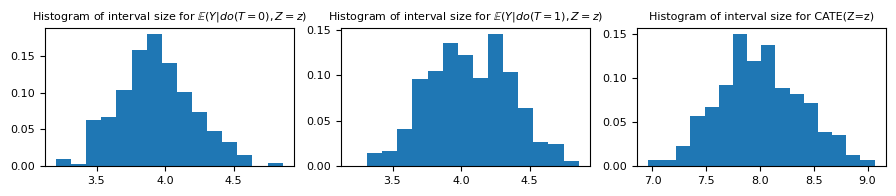

In [15]:
fig, ax = plt.subplots(ncols=3, figsize=(9, 2))
aux_hist = np.hstack([df_val.ic_size_t_0, df_val.ic_size_t_1])
min_hist, max_hist = np.min(aux_hist), np.max(aux_hist)
ax[0].hist(df_val.ic_size_t_0, bins=np.linspace(min_hist, max_hist, 16), weights=np.ones_like(df_val.ic_size_t_0)/df_val.shape[0])
ax[1].hist(df_val.ic_size_t_1, bins=np.linspace(min_hist, max_hist, 16), weights=np.ones_like(df_val.ic_size_t_1)/df_val.shape[0])
ax[2].hist(df_val_cate.cate_ci_size, bins=16, weights=np.ones_like(df_val_cate.cate_ci_size)/df_val_cate.shape[0])
ax[0].set_title("Histogram of interval size for $\mathbb{E}(Y | do(T=0), Z=z)$", fontsize="medium")
ax[1].set_title("Histogram of interval size for $\mathbb{E}(Y | do(T=1), Z=z)$", fontsize="medium")
ax[2].set_title("Histogram of interval size for CATE(Z=z)", fontsize="medium")
plt.tight_layout()

Mesmo nossos ICs individuais tendo sido construídos para 1 - \alpha = 0.9, nosso IC para o cate deveria ser de apenas 1 - 0.1 - 0.1 = 0.8, mas como discutido anteriormente, ele é muito grosseiro e na verdade fica bem melhor que isso.

In [16]:
df_val_cate.match_cate.mean()

1.0

___

Mostrar por fim como ficaram nossas previsões e concluir que fizemos um bom trabalho nas estimativas tanto do CATE quanto das esperanças com do.

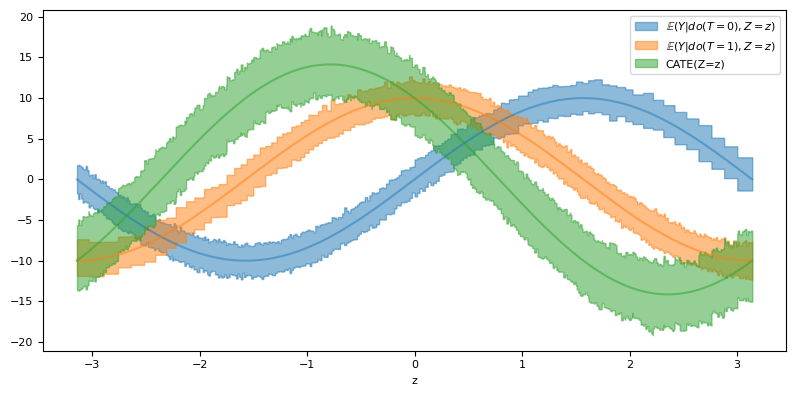

In [17]:
confouder_plot = np.linspace(XZ_test.confounder.min(), XZ_test.confounder.max(), 10_001)
ci_t1_plot = model_t1.predict(confouder_plot.reshape(-1, 1)).T
ci_t0_plot = model_t0.predict(confouder_plot.reshape(-1, 1)).T
ci_cate_plot = ci_t1_plot - ci_t0_plot[::-1,]

fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(confouder_plot, func_0(confouder_plot), alpha=0.5, c="C0")
ax.plot(confouder_plot, func_1(confouder_plot), alpha=0.5, c="C1")
ax.plot(confouder_plot, func_1(confouder_plot) - func_0(confouder_plot), alpha=0.5, c="C2")

ax.fill_between(confouder_plot, *ci_t0_plot, alpha=0.5, label="$\mathbb{E}(Y | do(T=0), Z=z)$", color="C0")
ax.fill_between(confouder_plot, *ci_t1_plot, alpha=0.5, label="$\mathbb{E}(Y | do(T=1), Z=z)$", color="C1")
ax.fill_between(confouder_plot, *ci_cate_plot, alpha=0.5, label="CATE(Z=z)", color="C2")

ax.set_xlabel("z")
ax.legend()
plt.tight_layout()

___